# Quantum Machine Learning for Satellite Data Analysis with Qiskit

HDCRS School, Day 2, Hands-on 2

## Setting up the environment


* Instructions for Colab: run the following block.
* Instructions for other environments: clone the hdcrs-school-2025 repo, create a virtual environment with `python -m venv .qiskit_venv`, activate your environment (`.qiskit_venv\Scripts\activate` on Windows, `.qiskit_venv/bin/activate` on Linux) and run `pip install -r requirements.txt`.

In [ ]:
github_repo_url = 'https://github.com/delilbasic1/hdcrs-school-2025.git'
!git clone {github_repo_url}

import os

repo_folder_name = 'hdcrs-school-2025'
os.chdir(repo_folder_name)

!bash install_requirements.sh

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.0 MB/s eta 0:00:00
  DEPRECATION: Building 'pylatexenc' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pylatexenc'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel

Required packages successfully installed.


## Importing libraries

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import minmax_scale

In [7]:
!pip list | grep qiskit

qiskit                                2.0.2
qiskit-algorithms                     0.3.1
qiskit-machine-learning               0.8.2


# Quantum Kernel Machine Learning

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this section, you will learn how to define quantum kernels using `qiskit-machine-learning`.

## 1. Introduction

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix:

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms. They can also be leveraged in new quantum kernel methods like [QSVC](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) class  provided by `qiskit-machine-learning`.

## 2. Classification

This section illustrates a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the dataset

For this example, we will use a cloud detection dataset, taking labeled pixels from the following image:

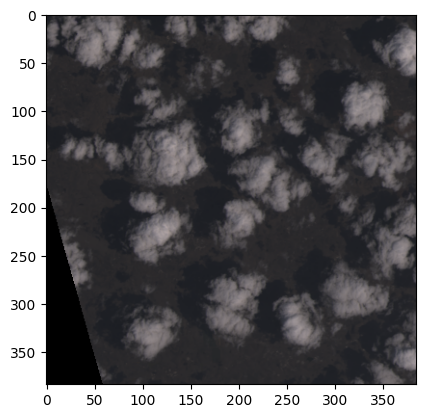

In [9]:
# Load and show image
clouds = plt.imread("clouds.png")
plt.imshow(clouds)

In [10]:
x=np.array([[0.33660889, 0.32368469, 0.3624115 , 0.36825562],
        [0.11776733, 0.1244812 , 0.14308167, 0.13162231],
        [0.29046631, 0.27635193, 0.28895569, 0.33744812],
        [0.12240601, 0.12930298, 0.14820862, 0.1375885 ],
        [0.14660645, 0.15046692, 0.16618347, 0.1741333 ],
        [0.17410278, 0.17253113, 0.18081665, 0.22900391],
        [0.16604614, 0.16191101, 0.17205811, 0.21888733],
        [0.17529297, 0.16802979, 0.17779541, 0.23057556],
        [0.11140442, 0.11955261, 0.14117432, 0.11462402],
        [0.17411804, 0.16534424, 0.17204285, 0.25767517],
        [0.11982727, 0.12678528, 0.14642334, 0.12734985],
        [0.12060547, 0.12710571, 0.14631653, 0.12973022],
        [0.46794128, 0.43930054, 0.43336487, 0.52716064],
        [0.25779724, 0.25082397, 0.25953674, 0.30126953],
        [0.16986084, 0.16239929, 0.17098999, 0.22808838],
        [0.36778259, 0.35125732, 0.36425781, 0.41357422],
        [0.53326416, 0.50579834, 0.52456665, 0.58334351],
        [0.15888977, 0.15670776, 0.17240906, 0.20199585],
        [0.16931152, 0.16323853, 0.17062378, 0.23516846],
        [0.18353271, 0.17266846, 0.17565918, 0.26786804],
        [0.11529541, 0.12242126, 0.14280701, 0.1194458 ],
        [0.23855591, 0.23344421, 0.24090576, 0.28564453],
        [0.17704773, 0.17477417, 0.18412781, 0.22543335],
        [0.21888733, 0.21340942, 0.22323608, 0.25842285],
        [0.16958618, 0.16503906, 0.17256165, 0.21955872],
        [0.15481567, 0.15348816, 0.16622925, 0.20500183],
        [0.19000244, 0.18000793, 0.19348145, 0.25866699],
        [0.23318481, 0.22940063, 0.2233429 , 0.27503967],
        [0.38456726, 0.3674469 , 0.37969971, 0.41423035],
        [0.44223022, 0.41473389, 0.41790771, 0.49299622],
        [0.29367065, 0.27616882, 0.28453064, 0.34519958],
        [0.57420349, 0.54309082, 0.5592804 , 0.62313843],
        [0.18733215, 0.17915344, 0.18217468, 0.26069641],
        [0.17715454, 0.17021179, 0.17669678, 0.25692749],
        [0.23231506, 0.21983337, 0.24739075, 0.28417969],
        [0.11859131, 0.1255188 , 0.14508057, 0.12814331],
        [0.16903687, 0.16661072, 0.17854309, 0.21243286],
        [0.15664673, 0.15592957, 0.16627502, 0.21252441],
        [0.12527466, 0.13235474, 0.15403748, 0.1315918 ],
        [0.14453125, 0.14602661, 0.16731262, 0.17227173],
        [0.28103638, 0.26570129, 0.29647827, 0.33381653],
        [0.45504761, 0.43771362, 0.45611572, 0.49279785],
        [0.16545105, 0.16047668, 0.16941833, 0.22348022],
        [0.24757385, 0.23910522, 0.24110413, 0.29104614],
        [0.15583801, 0.1569519 , 0.1806488 , 0.18310547],
        [0.16333008, 0.1594696 , 0.16856384, 0.21995544],
        [0.15588379, 0.15719604, 0.17692566, 0.18217468],
        [0.17530823, 0.16882324, 0.17770386, 0.23838806],
        [0.16377258, 0.15945435, 0.16990662, 0.22151184],
        [0.19226074, 0.19122314, 0.21583557, 0.22314453],
        [0.13899231, 0.14207458, 0.15930176, 0.16157532],
        [0.35821533, 0.35061646, 0.35258484, 0.38368225],
        [0.11575317, 0.12295532, 0.14137268, 0.1264801 ],
        [0.19422913, 0.18617249, 0.21159363, 0.24835205],
        [0.18670654, 0.18016052, 0.18847656, 0.25140381],
        [0.42216492, 0.40255737, 0.41215515, 0.46363831],
        [0.10890198, 0.11764526, 0.13725281, 0.11257935],
        [0.3112793 , 0.30015564, 0.31013489, 0.35522461],
        [0.13923645, 0.14096069, 0.16209412, 0.16732788],
        [0.17616272, 0.1710968 , 0.17976379, 0.24275208],
        [0.32830811, 0.31552124, 0.33570862, 0.36228943],
        [0.17294312, 0.16773987, 0.17518616, 0.24156189],
        [0.40548706, 0.38407898, 0.39657593, 0.44950867],
        [0.1776123 , 0.1690979 , 0.17617798, 0.23930359],
        [0.27427673, 0.26319885, 0.26994324, 0.32789612],
        [0.3006134 , 0.29193115, 0.32316589, 0.3218689 ],
        [0.18719482, 0.18200684, 0.18745422, 0.23696899],
        [0.2973938 , 0.28726196, 0.29316711, 0.35153198],
        [0.29960632, 0.28573608, 0.30421448, 0.34477234],
        [0.1302948 , 0.13525391, 0.15234375, 0.14491272],
        [0.16699219, 0.16149902, 0.16775513, 0.25613403],
        [0.11447144, 0.1217804 , 0.14108276, 0.12446594],
        [0.37768555, 0.36351013, 0.36491394, 0.41516113],
        [0.16731262, 0.16314697, 0.17388916, 0.22938538],
        [0.37538147, 0.36260986, 0.38041687, 0.41471863],
        [0.1207428 , 0.12683105, 0.14575195, 0.13519287],
        [0.18487549, 0.17810059, 0.18255615, 0.2255249 ],
        [0.15942383, 0.15827942, 0.16749573, 0.22021484],
        [0.15873718, 0.15817261, 0.17289734, 0.19494629],
        [0.16819763, 0.16241455, 0.17269897, 0.22241211],
        [0.1197052 , 0.12612915, 0.14492798, 0.12878418],
        [0.17480469, 0.16777039, 0.17584229, 0.23774719],
        [0.12001038, 0.12677002, 0.14683533, 0.13453674],
        [0.41098022, 0.38693237, 0.39222717, 0.46896362],
        [0.20825195, 0.19773865, 0.21652222, 0.25714111],
        [0.17788696, 0.17579651, 0.19213867, 0.2150116 ],
        [0.18971252, 0.18414307, 0.19285583, 0.25030518],
        [0.48455811, 0.46199036, 0.47473145, 0.52926636],
        [0.4229126 , 0.40196228, 0.39260864, 0.46818542],
        [0.16052246, 0.16142273, 0.18115234, 0.19120789],
        [0.14343262, 0.14253235, 0.15565491, 0.18315125],
        [0.44081116, 0.41665649, 0.42106628, 0.48925781],
        [0.1809082 , 0.17726135, 0.19271851, 0.22265625],
        [0.33876038, 0.32096863, 0.3344574 , 0.39401245],
        [0.30027771, 0.29135132, 0.31872559, 0.33105469],
        [0.12367249, 0.13104248, 0.15014648, 0.1388092 ],
        [0.11764526, 0.12409973, 0.1426239 , 0.13931274],
        [0.11488342, 0.12249756, 0.14292908, 0.12321472],
        [0.31427002, 0.29353333, 0.2966156 , 0.37911987],
        [0.38813782, 0.37423706, 0.39625549, 0.42344666]])

y = np.array([1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1,
              -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1,
              -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1,
              -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1,
              1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1])

**How do we visualize a 4-dimensional dataset?**

In [14]:
pca = PCA(n_components=2)
x = pca.fit_transform(x)

We have measurements for four wavelengths: blue (450-515 nm), green (520-600 nm), red (630-680 nm) and NIR (845-885 nm) with labels '0' (no-clouds) and '1' (clouds).

We need to scale the features to $[0, 2\pi]$ so that we can encode them as rotation gates.

In [13]:
x = minmax_scale(x, (0,np.pi))
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

Let's plot it now:

ValueError: Supply a 'c' argument or a 'color' kwarg but not both; they differ but their functionalities overlap.

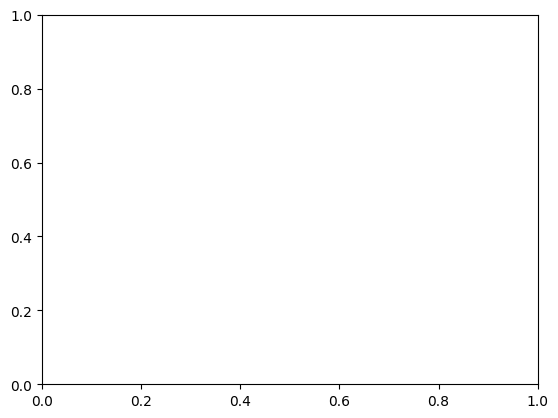

In [17]:
plt.scatter(*(x_train[y_train==-1].T), color='red', marker='o', label='x_train, class -1')
plt.scatter(*(x_train[y_train==1].T), color='blue', marker='o', label='x_train, class 1')
plt.scatter(*(x_test[y_test==-1].T), color='red', marker='x', label='x_test, class -1')
plt.scatter(*(x_test[y_test==1].T), color='blue', marker='x', label='x_test, class 1')
plt.legend()
plt.ylabel('x0')
plt.xlabel('x1')
plt.title('Train-test split');

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data.

We use the [FidelityQuantumKernel](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) class, and pass two input arguments to its constructor:

1. `feature_map`: in this case, a two-qubit [ZZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap).

2. `fidelity`: in this case, the [ComputeUncompute](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.state_fidelities.ComputeUncompute.html) fidelity subroutine that leverages the [Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler) primitive.

**NOTE:** If you don't pass a `Sampler` or `Fidelity` instance, then the instances of the reference `Sampler` and `ComputeUncompute` classes (found in `qiskit.primitives`) will be created by default.

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

clouds_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

clouds_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=clouds_feature_map)

### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the [SVC](https://scikit-learn.org/stable/modules/svm.html) algorithm from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways:

1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Kernel as a callable function

We define a SVC model and directly pass the `evaluate` function of the quantum kernel as a callable. Once the model is created, we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [ ]:
from sklearn.svm import SVC

clouds_svc = SVC(kernel=cloud_kernel.evaluate)


clouds_svc.fit(x_train, y_train)

clouds_score_callable_function = clouds_svc.score(x_test, y_test)

print(f"Callable kernel classification test score: {clouds_score_callable_function}")

Callable kernel classification test score: 1.0


#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm.

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

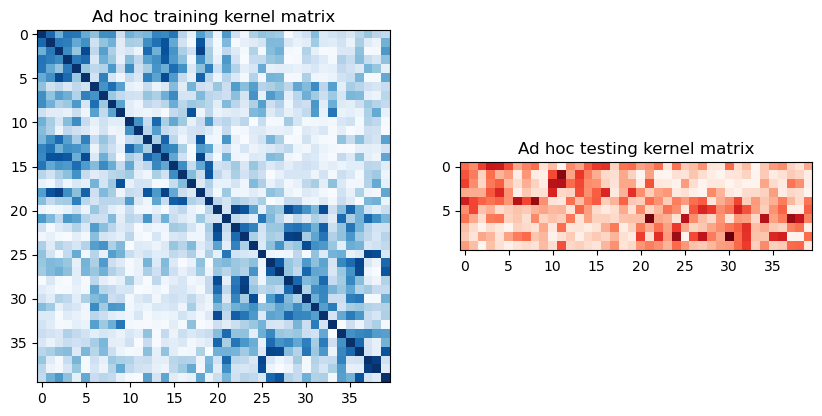

In [ ]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [ ]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### 2.4. Classification with QSVC

`QSVC` is an alternative training algorithm provided by `qiskit-machine-learning` for convenience. It is an extension of `SVC` that takes in a quantum kernel instead of the `kernel.evaluate` method shown before.

In [ ]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


### 2.5. Evaluation of models used for classification

In [ ]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00
